# Tools and Dependencies:

In [14]:
#------====SHELL COMMANDS FOR DEPENDENCIES====-------
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install networkx --upgrade 
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install seaborn


Requirement already up-to-date: networkx in /usr/local/envs/py3env/lib/python3.5/site-packages (2.2)


In [15]:
#-----===DATA ANALYSIS AND CLEANING===-----
import numpy as np 
import pandas as pd
from itertools import combinations
import networkx as nx

#-----===DATA VISUALIZATIONS===-----
import matplotlib.pyplot as plt
import seaborn as sns



#-----===NATURAL LANGUAGE PROCESSING===-----
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

#-----===MACHINE LEARNING LIBRARIES===-----
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import initializers
import tensorflow as tf
import keras


# -----===Data Processing===-----
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#   -----====Models====-----
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# -----====Evaluation Metrics and Tuning====-----
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score, precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

Originally I was going to scrape the MEDLINE API to get data necessary for this project, but due to time constraints and the fact that running a full speed scraper on the whole of MEDLINE would take weeks to compile the information even at full speed, which consequently would probably get me banned, so I decided otherwise. Luckily the scraping work had already been done by a Kaggle user who uploaded multiple zip files containing the information I required.

[MEDLINE and MeSH Data Set](https://www.kaggle.com/alucaria/medline)

When compiling the zip files to extract the data I found that 3MB on the tail end of the data was corrupted. I found the corrupted data to be unsalvageable. So I dropped the tail of the data set for my purposes.

# Data Cleaning 1:

In [4]:
# Read in and Clean only the required data from the very large CSV (2GB)
mesh = pd.read_csv('mesh.csv',usecols=['pmid', 'descriptor_name'])
mesh = mesh.loc[0:46999997, :].copy()
mesh['pmid'] = mesh['pmid'].astype(int) 
mesh['descriptor_name'] = mesh['descriptor_name'].str.replace('-', '')
mesh['descriptor_name'] = mesh['descriptor_name'].str.replace(' ', '')
mesh['descriptor_name'] = mesh['descriptor_name'].str.replace(',', '')
mesh['descriptor_name'] = mesh['descriptor_name'].str.strip()
mesh['descriptor_name'] = mesh['descriptor_name'].apply(lambda x: x.ljust(len(x) + 1))
mesh.head()

/usr/local/envs/py3env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pmid,descriptor_name
0,20220350,Adolescent
1,20220350,Child
2,20220350,GeneticTesting
3,20220350,Humans
4,20220350,MarfanSyndrome


The terms are individual data points paired with their corresponding PMID (Identifies the article/paper). By grouping by PMID we compile of the MeSH terms that identify the papers as shown below:

In [5]:
mesh_papers = mesh.groupby(mesh['pmid']).sum()
mesh_papers['descriptor_name'] = mesh_papers['descriptor_name'].str.strip().copy()
mesh_papers['counts'] = mesh_papers['descriptor_name'].copy().apply(lambda x: len(x))
mesh_papers.head()

,descriptor_name,counts
pmid,,
30970,AdrenergicbetaAntagonists Female FetalHeart Hu...,163
30971,Acebutolol AdrenergicbetaAntagonists Female Hu...,131
30972,BacterialInfections Chemotaxis Humans Hydrogen...,117
30973,AdrenergicbetaAntagonists CoronaryDisease Dela...,88
30974,AcuteDisease AmbulatoryCare AntipsychoticAgent...,130


In [6]:
mesh_terms_counts = mesh['descriptor_name'].value_counts(sort=True)
mesh_terms_counts = pd.DataFrame(mesh_terms_counts)

#Remove all terms that occur less than 10 times (vocabulary reduces to 25909 from 27617)
mesh_terms_counts = mesh_terms_counts.loc[mesh_terms_counts['descriptor_name'] >= 10]
mesh_terms_counts = mesh_terms_counts.reset_index()
mesh = mesh.loc[mesh['descriptor_name'].isin(list(mesh_terms_counts['index']))]
mesh_terms_counts.head()

,index,descriptor_name
0,Humans,3056783
1,Female,1428199
2,Male,1405011
3,Animals,1105720
4,Adult,823466


In [9]:
print('MeSH Terms in Current Dataset: {}'.format(len(mesh_terms_counts)))

MeSH Terms in Current Dataset: 25909


Visualizations were saved as png file, due to the increased memory and computational demands of processing the data. I erased them after running the code.

In [ ]:
#For Visualization 1 
#mesh_terms_counts = mesh['descriptor_name'].value_counts(sort=True)
#mesh_terms_counts = pd.DataFrame(mesh_terms_counts)
mesh_terms_counts30 = mesh_terms_counts.head(30).copy()

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(y=mesh_terms_counts.index, x=mesh_terms_counts['descriptor_name'])
ax.set_xlabel('Frequency')
ax.set_ylabel('MeSH Descriptor')
ax.set_title('30 Most Frequently use MeSH Descriptors(1973-2016)')
plt.show() 
plt.savefig('30_freq.png')

### Saving Data:

Once the data was cleaned and organized by PMID it was exported to a CSV file in order to restart the kernel and free up memory.

In [ ]:
mesh_papers.to_csv('mesh_papers.csv')

# Modelling:

Cleaning Script to prepare Dataframe from mesh_papers.csv for parsing by Networkx and Word2Vec. 

In [13]:
# Cleaning Script to prepare Dataframe from mesh_papers.csv for parsing by Networkx and Word2Vec. 
mesh_papers = pd.read_csv('mesh_papers.csv')
mesh_papers['descriptor_name'] = mesh_papers['descriptor_name'].str.strip()
mesh_papers['descriptor_name'] = mesh_papers['descriptor_name'].str.replace(',','')
mesh_papers['descriptor_name'] = mesh_papers['descriptor_name'].str.split()
mesh_papers = mesh_papers.sort_values(by='pmid', ascending=True, na_position='first')
mesh_papers['mesh_counts'] = mesh_papers['descriptor_name'].copy().apply(lambda x: len(x))
mesh_papers = mesh_papers.loc[(mesh_papers['mesh_counts'] <=30) & (mesh_papers['mesh_counts'] >= 3)]
mesh_counts = mesh_papers['mesh_counts'].copy()
mesh_papers = mesh_papers.drop(['pmid', 'mesh_counts'], 1)
mesh_papers = mesh_papers['descriptor_name'].copy()

### Histogram of MeSH terms per Article:

Created to determine the ideal window for word2vec model. It would seem most articles have between 3 to 16 terms the median and mean being closest to 10, based on this I decided my window would be 5 (10/2, 5 words before and 5 words after).

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Mean = 10.68
Median = 10.0


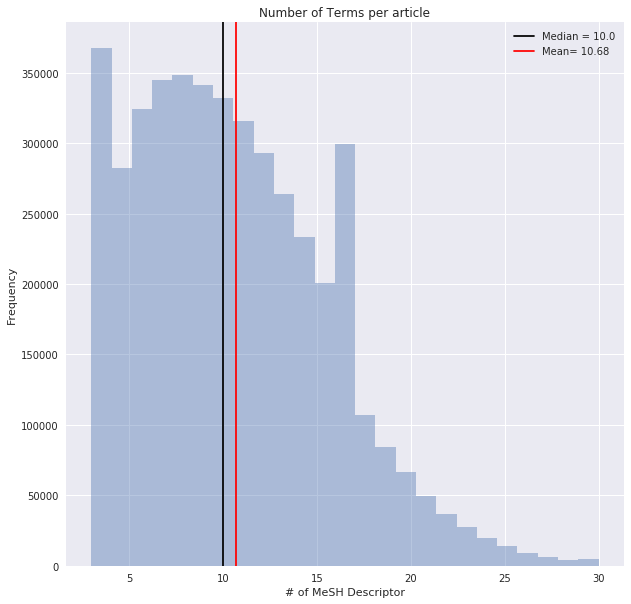

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(mesh_counts, bins=25, kde=False)
ax.set_title('Number of Terms per article')
median = ax.axvline(mesh_counts.median(), color='black' )
mean = ax.axvline(mesh_counts.mean(), color='red')
ax.set_xlabel('# of MeSH Descriptor')
ax.set_ylabel('Frequency')
ax.legend((median, mean), ('Median = {}'.format(mesh_counts.median()), 'Mean= {}'.format(round(mesh_counts.mean(), 2))))
plt.savefig('histogram_mesh.png')
print('Mean = {}'.format(round(mesh_counts.mean(), 2)))
print('Median = {}'.format(mesh_counts.median()))
plt.show()

### Word2Vec:

Running the Word2Vec alrogithm to determine 300-dimensional word vectors for each MeSH term using the data from over 4M papers. These vectors will be normalized as we do not require the length of the vector (represents context), only the distance between vectors which can be measure using the default similarities in gensim (cosine similarity).

In [ ]:
w2v_mesh = word2vec.Word2Vec(mesh_papers, 
                             size=300, 
                             window=5, #We determined this number for the Histogram.
                             min_count=3, 
                             workers=10, 
                             sg=1, 
                             hs=1, 
                             min_alpha=0.0001, 
                             seed=42, 
                             max_final_vocab=None, 
                             max_vocab_size=None, 
                             sample=1e-3)

### t-SNE:
Due to the prolonged time with no result, I decided to omit this visualization from the notebook and presentation, but included the code.

In [27]:
# from sklearn.manifold import TSNE

# def tsne_plot(model, fname):
#     labels = []
#     tokens = []
#     counter = 0
#     for word in model.wv.vocab:
#       counter += 1
#       while counter <= 200:
#         tokens.append(model[word])
#         labels.append(word)
    
#     tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1000, random_state=3)
#     new_values = tsne_model.fit_transform(tokens)

#     x = []
#     y = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
        
#     plt.figure(figsize=(30, 30)) 
#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
#     plt.savefig(fname)
#     plt.show()
    
# tsne_plot(w2v_mesh, 'tsne_mesh.png')

### Graph Parsing and Data Compilation Functions:

PMID numbers are assigned in chronological order when the articles are submitted to pubmed. I was able to use the PMID numbers to search PubMed and find the corresponding year for the first and last paper in each slice of the dataset. The split is somewhat arbitrary as I chose to slice the dataset in 4 equal parts but you can see from the groups below that each group includes close to a decade worth of data. 

The total number of papers included is 4,464,357 .

Since most all research usually built upon older research using 2 consecutive eras we can model the link prediction as a before and after problem where we use the data from a past graph to predict possible edges and the future graph to validate the accuracy of the links predicted.
 
Groups:
    1. 1973 - 1988
    2. 1988 - 1998
    3. 1998 - 2005
    4. 2005 - 2016

In [ ]:
def generate_graph(df):
    '''Generates a Graph using all paired combinations of MeSH terms, being an undirected graph without multiple edges between nodes permutations were uneccesary.'''
    G = nx.Graph()
    generator = df.apply(lambda x: combinations(x, 2))
    for gen in generator:
        G.add_edges_from(list(gen))
        return G


def generate_raw_dataset(graph1, graph2):
    '''Using the data from graphs from 2 consecutive time periods this function determins all the edges that exist in the future time that DO NOT exist in the prior time period, 
    and assign a boolean value of True or False depending on the existence of edges. (True if it exists in the future graph, False if it does not.)'''
    dataset = pd.DataFrame()
    dataset['Pairs'] = list(nx.non_edges(graph1)) 
    dataset['Future Edges'] = [graph2.has_edge(*i) for i in dataset['Pairs']] 
    return dataset

def even_sample_400k(df, group):
    '''In order to validate link predictions using supervised learning we take a subsample of 400,000 instances of possible edges, half True half False'''
    nrows = len(df)
    sample_n = 200000
    df = df.groupby(group).apply(lambda x: x.sample(sample_n))
    df = df.copy().reset_index(drop=True)
    return df

def get_sims(df, graph):
    '''Using the graph of the of the past time period this function measures link prediction coefficients and includes them in the datafram as features.'''
    df['PFA'] = list(nx.preferential_attachment(graph, ebunch=df['Pairs']))
    df['PFA'] = df['PFA'].apply(lambda x: x[2])
    df['jaccard'] = list(nx.jaccard_coefficient(graph, ebunch=df['Pairs']))
    df['jaccard'] = df['jaccard'].apply(lambda x: x[2])
    df['adamic_adar'] = list(nx.adamic_adar_index(graph, ebunch=df['Pairs']))
    df['adamic_adar'] = df['adamic_adar'].apply(lambda x: x[2])
    df['resource'] = list(nx.resource_allocation_index(graph, ebunch=df['Pairs']))
    df['resource'] = df['resource'].apply(lambda x: x[2])
    df['common'] = df['Pairs'].copy().apply(lambda x: list(nx.common_neighbors(graph, u=x[0], v=x[1])))
    df['common'] = df['common'].apply(lambda x: len(x))
    return df

def w2v_sims(df, model):
    '''Does the same as the above function but uses Word2Vec similarity instead.'''
    df['w2v'] = df['Pairs'].copy()
    df['w2v'] = df['w2v'].apply(lambda x: model.similarity(x[0], x[1]))
    return df

In [6]:
#Split the data into 4 seperate consecutive 'time periods'
mesh_papers = np.array_split(mesh_papers, 4)

'''Generate Graphs for each time period INCLUDING the previous data in each consecutive graph. 
This is both extremely memory hungry and computationally intensive and takes hours to run, I personally did this step in pairs As shown in the lines below.'''
G_mesh_1 = generate_graph(pd.concat(mesh_papers[0:1]))
G_mesh_2= generate_graph(pd.concat(mesh_papers[0:2]))
G_mesh_3 = generate_graph(pd.concat(mesh_papers[0:3]))
G_mesh_4 = generate_graph(pd.concat(mesh_papers[0:4]))


#Take 400k samples from each time period.
df_G1 = even_sample_400k(generate_raw_dataset(G_mesh_1, G_mesh_2), 'Future Edges')
df_G2 = even_sample_400k(generate_raw_dataset(G_mesh_2, G_mesh_3), 'Future Edges')
df_G3 = even_sample_400k(generate_raw_dataset(G_mesh_3, G_mesh_4), 'Future Edges')
df_G1.head()

# Calculate similarity measurements from networkx
df_G1 = get_sims(df_G1, G_mesh_1)
df_G2 = get_sims(df_G2, G_mesh_2)
df_G3 = get_sims(df_G3, G_mesh_3)
df_G1.head()

#All were saved to CSV due to the prolonged time it took to process and clean the data. Imported and the word2vec similarity was added using function.


df_G1 = pd.read_csv('SampleGraph1_400k.csv', converters={'Pairs': ast.literal_eval})
df_G2 = pd.read_csv('SampleGraph2_400k.csv', converters={'Pairs': ast.literal_eval})
df_G3 = pd.read_csv('SampleGraph3_400k.csv', converters={'Pairs': ast.literal_eval})

df_G1 = w2v_sims(df_G1, w2v_mesh).drop('Unnamed: 0', 1)
df_G2 = w2v_sims(df_G2, w2v_mesh).drop('Unnamed: 0', 1)
df_G3 = w2v_sims(df_G3, w2v_mesh).drop('Unnamed: 0', 1)

#New Data was saved to CSV to use for final modelling.
df_G1.to_csv('SampleG1_Final.csv')
df_G2.to_csv('SampleG2_Final.csv')
df_G3.to_csv('SampleG3_Final.csv')

,Unnamed: 0,Pairs,Future Edges,PFA,jaccard,adamic_adar,resource,common
0,0,"('Sialomucins', 'LambertEatonMyasthenicSyndrome')",False,43215,0.061224,2.571336,0.002351,24
1,1,"('VancomycinResistance', 'Denervation')",False,1409929,0.036854,15.231938,0.024450,134
2,2,"('TobaccoMosaicVirus', 'ComplementC8')",False,244839,0.101395,12.318307,0.017288,109
3,3,"('PregnancyUnwanted', 'ExpertSystems')",False,704490,0.111761,20.602983,0.048547,172
4,4,"(""PracticePatternsDentists'"", 'IoglycamicAcid')",False,36729,0.023965,1.134051,0.000694,11


The final result of these functions is as shown below, a tuple representing the pair of MeSH terms being analyzed, and 5 measurments (4 based on graph analysis + w2v cosine similarity

In [16]:
import ast
df_G1 = pd.read_csv('SampleG1_Final.csv', converters={'Pairs': ast.literal_eval})
df_G2 = pd.read_csv('SampleG2_Final.csv', converters={'Pairs': ast.literal_eval})
df_G3 = pd.read_csv('SampleG3_Final.csv', converters={'Pairs': ast.literal_eval})


df_G1 = df_G1.drop('Unnamed: 0', 1)
df_G2 = df_G2.drop('Unnamed: 0', 1)
df_G3 = df_G3.drop('Unnamed: 0', 1)

df_G2.head()

,Pairs,Future Edges,PFA,adamic_adar,resource,common,w2v
0,"(Sialomucins, LambertEatonMyasthenicSyndrome)",False,43215,2.571336,0.002351,24,0.049037
1,"(VancomycinResistance, Denervation)",False,1409929,15.231938,0.024450,134,-0.002600
2,"(TobaccoMosaicVirus, ComplementC8)",False,244839,12.318307,0.017288,109,0.102941
3,"(PregnancyUnwanted, ExpertSystems)",False,704490,20.602983,0.048547,172,0.083960
4,"(PracticePatternsDentists', IoglycamicAcid)",False,36729,1.134051,0.000694,11,0.019132


In [17]:
X = df_G1.copy().drop(['Pairs', 'Future Edges'], 1)
y = df_G1['Future Edges']

X_trainG1, X_testG1, y_trainG1, y_testG1 = train_test_split(X, y, random_state=3, stratify=y)

X2 = df_G2.copy().drop(['Pairs', 'Future Edges'], 1)
y2 = df_G2['Future Edges']

X_trainG2, X_testG2, y_trainG2, y_testG2 = train_test_split(X2, y2, random_state=3, stratify=y)

X3 = df_G3.copy().drop(['Pairs', 'Future Edges'], 1)
y3 = df_G3['Future Edges']

### Logistic Regression

Optimal hyperparameters for all models were determined using GridSearch but for the purposes of rerunning the cells the models were consolidated to only include those parameters.

Groups:

1. 1973 - 1988
2. 1988 - 1998
3. 1998 - 2005
4. 2005 - 2016

Key:

Model names immediately appended by a number indicates what TRAINING data was used for that model.

X and y appended by a number indicates the TEST data that was used to predict on.

In [18]:
plt.style.use('seaborn')

def plot_AUC(test, probas, model_name):
  '''Model takes the output of predict_probas and uses it to create an ROC visualization and calculates AUC'''
  false_pos, true_pos, auc = roc_curve(test, probas)
  plt.figure(figsize=(7,7))
  plt.plot(false_pos, true_pos)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([-0.005, 1, 0, 1.005])
  plt.xticks(np.arange(0,1, 0.05), rotation=90)
  plt.xlabel('False Positive')
  plt.ylabel('True Positive')
  plt.title('ROC Curve for {}'.format(model_name))
  print('AUC: {}'.format(roc_auc_score(test, probas)))
  plt.show()

Mean Training Set CV Score: 0.7977333333333334

Accuracy on Test: 0.79712

col_0         False  True 
Future Edges              
False         42437   7563
True          12725  37275

             precision    recall  f1-score   support

      False       0.77      0.85      0.81     50000
       True       0.83      0.75      0.79     50000

avg / total       0.80      0.80      0.80    100000


AUC: 0.8785818428000001


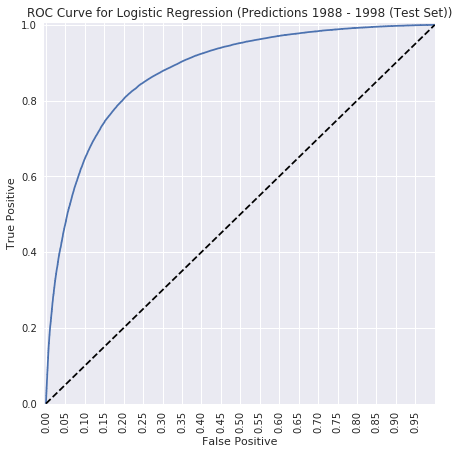

In [22]:
logreg1 = LogisticRegression(C=10, penalty='l1')
logreg1.fit(X_trainG1, y_trainG1)
train_cv_result_logreg1 = cross_val_score(logreg1, X_trainG1, y_trainG1, cv=5)
y_pred_logreg1 = logreg1.predict(X_testG1)
y_pred_probas_logreg1 = logreg1.predict_proba(X_testG1)[:, 1]
print('Mean Training Set CV Score: {}'.format(train_cv_result_logreg1.mean()))
print()
print('Accuracy on Test: {}'.format(accuracy_score(y_testG1, y_pred_logreg1)))
print()
print(pd.crosstab(y_testG1, y_pred_logreg1))
print()
print(classification_report(y_testG1, y_pred_logreg1))
print()
logreg1_X1_auc = plot_AUC(y_testG1, y_pred_probas_logreg1, 'Logistic Regression (Predictions 1988 - 1998 (Test Set))')

Accuracy on Test: 0.8081475

col_0          False   True 
Future Edges                
False         166075   33925
True           42816  157184

             precision    recall  f1-score   support

      False       0.80      0.83      0.81    200000
       True       0.82      0.79      0.80    200000

avg / total       0.81      0.81      0.81    400000

AUC: 0.8858152287750001


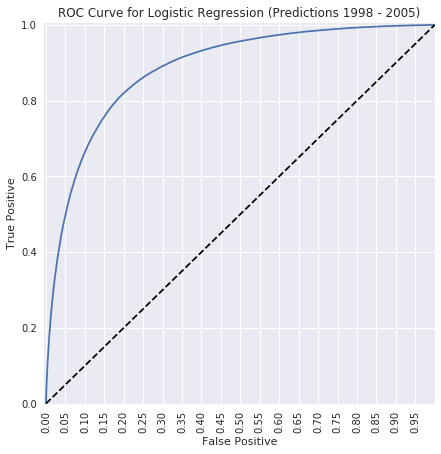

In [23]:
y2_pred_logreg1 = logreg1.predict(X2)
y2_pred_probas_logreg1 = logreg1.predict_proba(X2)[:, 1]
print('Accuracy on Test: {}'.format(accuracy_score(y2, y2_pred_logreg1)))
print()
print(pd.crosstab(y2, y2_pred_logreg1))
print()
print(classification_report(y2, y2_pred_logreg1))
logreg1_X2_auc = plot_AUC(y2, y2_pred_probas_logreg1, 'Logistic Regression (Predictions 1998 - 2005)')

Accuracy on Test: 0.80327

col_0          False   True 
Future Edges                
False         164184   35816
True           42876  157124

             precision    recall  f1-score   support

      False       0.79      0.82      0.81    200000
       True       0.81      0.79      0.80    200000

avg / total       0.80      0.80      0.80    400000


AUC: 0.88177396835


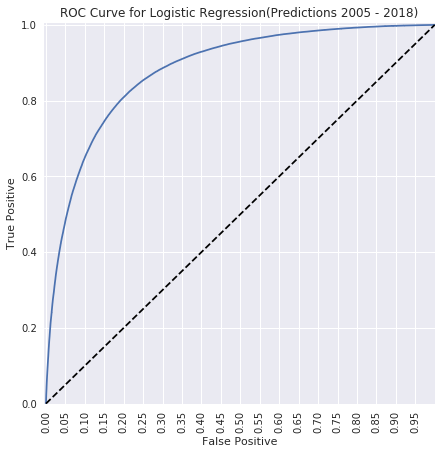

In [24]:
y3_pred_logreg1 = logreg1.predict(X3)
y3_pred_probas_logreg1 = logreg1.predict_proba(X3)[:, 1]
print('Accuracy on Test: {}'.format(accuracy_score(y3, y3_pred_logreg1)))
print()
print(pd.crosstab(y3, y3_pred_logreg1))
print()
print(classification_report(y3, y3_pred_logreg1))
print()
logreg1_X3_auc = plot_AUC(y3, y3_pred_probas_logreg1, 'Logistic Regression(Predictions 2005 - 2018)')

These results are promising as the model generalized well to both the next immediate time period and the third time period meaning the patterns the model found in when inputting the 'similarity vectors' are meaninful enough to predict new relationships between MeSH terms. In order to confirm this though we will run logistic Regression in the same way for the second time period and compare the results.

I repeat this process for the second time period on the third time period. Subsequently we'll repeat this process using Random Forests to compare results.

### Logistic Regression 2 

Mean Training Set CV Score: 0.8043633333333332

Accuracy on Test: 0.80322

col_0         False  True 
Future Edges              
False         42349   7651
True          12027  37973

             precision    recall  f1-score   support

      False       0.78      0.85      0.81     50000
       True       0.83      0.76      0.79     50000

avg / total       0.81      0.80      0.80    100000


AUC: 0.88634757


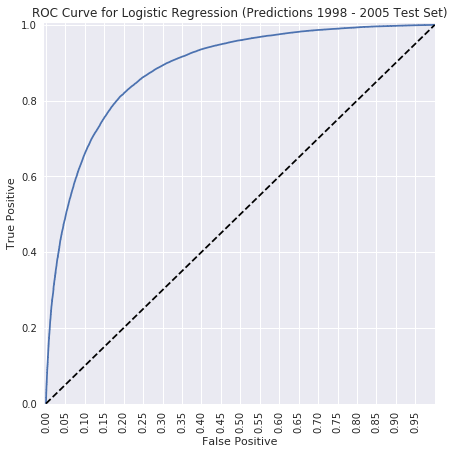

In [26]:
logreg2 = LogisticRegression(C=10, penalty='l1')
logreg2.fit(X_trainG2, y_trainG2)
train_cv_result_logreg2 = cross_val_score(logreg2, X_trainG2, y_trainG2, cv=5)
y2_pred_logreg2 = logreg2.predict(X_testG2)
y2_pred_probas_logreg2 = logreg2.predict_proba(X_testG2)[:, 1]
print('Mean Training Set CV Score: {}'.format(train_cv_result_logreg2.mean()))
print()
print('Accuracy on Test: {}'.format(accuracy_score(y_testG2, y2_pred_logreg2)))
print()
print(pd.crosstab(y_testG2, y2_pred_logreg2))
print()
print(classification_report(y_testG2, y2_pred_logreg2))
print()
logreg2_X2_auc = plot_AUC(y_testG2, y2_pred_probas_logreg2, 'Logistic Regression (Predictions 1998 - 2005 Test Set)')

Accuracy on Test: 0.8044175

col_0          False   True 
Future Edges                
False         163942   36058
True           42175  157825

             precision    recall  f1-score   support

      False       0.80      0.82      0.81    200000
       True       0.81      0.79      0.80    200000

avg / total       0.80      0.80      0.80    400000


AUC: 0.8823451587250001


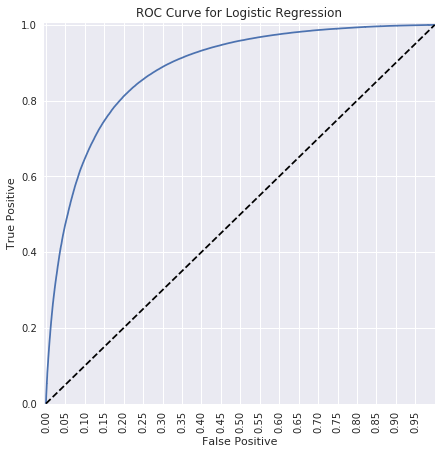

In [27]:
y3_pred_logreg2 = logreg2.predict(X3)
y3_pred_probas_logreg2 = logreg2.predict_proba(X3)[:, 1]
print('Accuracy on Test: {}'.format(accuracy_score(y3, y3_pred_logreg2)))
print()
print(pd.crosstab(y3, y3_pred_logreg2))
print()
print(classification_report(y3, y3_pred_logreg2))
print()
logreg2_X3_auc = plot_AUC(y3, y3_pred_probas_logreg2, 'Logistic Regression (Predictions 2005 - 2016)')

# Random Forest

In [19]:
rf_classifier1 = RandomForestClassifier(max_depth=None, n_estimators=500)
rf_classifier1.fit(X_trainG1, y_trainG1)
train_cv_result_rf1 = cross_val_score(rf_classifier1, X_trainG1, y_trainG1, cv=5)
y_pred_rf1 = rf_classifier1.predict(X_testG1)
y_pred_probas_rf1 = rf_classifier1.predict_proba(X_testG1)[:, 1]
print('Mean Training Set CV Score: {}'.format(train_cv_result_rf1.mean()))
print()
print('Accuracy on Test: {}'.format(accuracy_score(y_testG1, y_pred_rf1)))
print()
print(pd.crosstab(y_testG1, y_pred_rf1))
print()
print(classification_report(y_testG1, y_pred_rf1))

Mean Training Set CV Score: 0.8141599999999999

Accuracy on Test: 0.81405

col_0         False  True 
Future Edges              
False         39807  10193
True           8402  41598

             precision    recall  f1-score   support

      False       0.83      0.80      0.81     50000
       True       0.80      0.83      0.82     50000

avg / total       0.81      0.81      0.81    100000



AUC: 0.8905664052


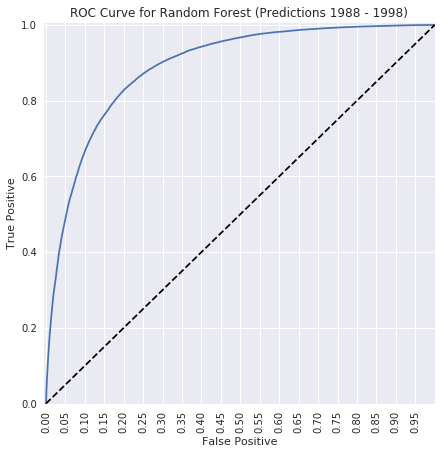

In [20]:
rf1_X1_auc = plot_AUC(y_testG1, y_pred_probas_rf1, 'Random Forest (Predictions 1988 - 1998)')

Accuracy on Test: 0.797335

col_0          False   True 
Future Edges                
False         171623   28377
True           52689  147311

             precision    recall  f1-score   support

      False       0.77      0.86      0.81    200000
       True       0.84      0.74      0.78    200000

avg / total       0.80      0.80      0.80    400000

AUC: 0.8840747108625001


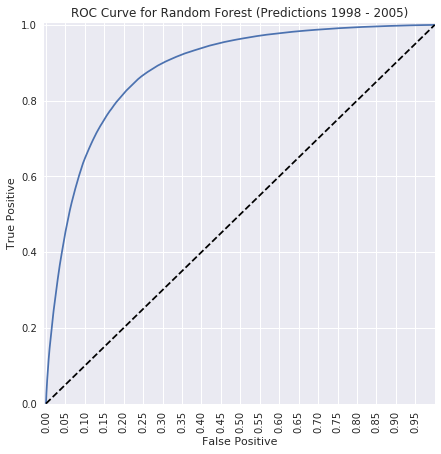

In [11]:
y2_pred_rf1 = rf_classifier1.predict(X2)
y2_pred_probas_rf1 = rf_classifier1.predict_proba(X2)[:, 1]
print('Accuracy on Test: {}'.format(accuracy_score(y2, y2_pred_rf1)))
print()
print(pd.crosstab(y2, y2_pred_rf1))
print()
print(classification_report(y2, y2_pred_rf1))
rf1_X2_auc = plot_AUC(y2, y2_pred_probas_rf1, 'Random Forest (Predictions 1998 - 2005)')

Accuracy on Test: 0.7850825

col_0          False   True 
Future Edges                
False         172437   27563
True           58404  141596

             precision    recall  f1-score   support

      False       0.75      0.86      0.80    200000
       True       0.84      0.71      0.77    200000

avg / total       0.79      0.79      0.78    400000

AUC: 0.8753256194375


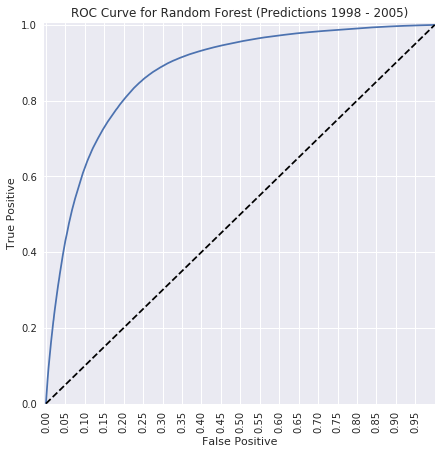

In [12]:
y3_pred_rf1 = rf_classifier1.predict(X3)
y3_pred_probas_rf1 = rf_classifier1.predict_proba(X3)[:, 1]
print('Accuracy on Test: {}'.format(accuracy_score(y3, y3_pred_rf1)))
print()
print(pd.crosstab(y3, y3_pred_rf1))
print()
print(classification_report(y3, y3_pred_rf1))
rf1_X3_auc = plot_AUC(y3, y3_pred_probas_rf1, 'Random Forest (Predictions 1998 - 2005)')

# Random Forest 2

In [21]:
rf_classifier2 = RandomForestClassifier(max_depth=10, n_estimators=500)
rf_classifier2.fit(X_trainG2, y_trainG2)
train_cv_result_rf2 = cross_val_score(rf_classifier2, X_trainG2, y_trainG2, cv=5)
y2_pred_rf2 = rf_classifier2.predict(X_testG2)
y2_pred_probas_rf2 = rf_classifier2.predict_proba(X_testG2)[:, 1]
print('Mean Training Set CV Score: {}'.format(train_cv_result_rf2.mean()))
print()
print('Accuracy on Test: {}'.format(accuracy_score(y_testG2, y2_pred_rf2)))
print()
print(pd.crosstab(y_testG2, y2_pred_rf2))
print()
print(classification_report(y_testG2, y2_pred_rf2))
rf2_X2_auc = plot_AUC(y_testG2, y2_pred_probas_rf2, 'Random Forest (Predictions 1998 - 2005)')

Mean Training Set CV Score: 0.82738

Accuracy on Test: 0.82827

col_0         False  True 
Future Edges              
False         40700   9300
True           7873  42127

             precision    recall  f1-score   support

      False       0.84      0.81      0.83     50000
       True       0.82      0.84      0.83     50000

avg / total       0.83      0.83      0.83    100000



ValueError: Found input variables with inconsistent numbers of samples: [400000, 100000]

AUC: 0.9048590346000001


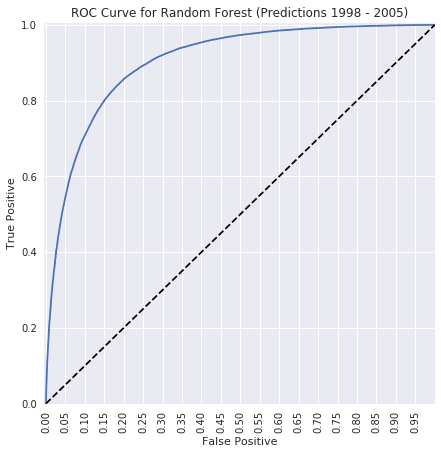

In [22]:
rf2_X2_auc = plot_AUC(y_testG2, y2_pred_probas_rf2, 'Random Forest (Predictions 1998 - 2005)')

Accuracy on Test: 0.8226

col_0          False   True 
Future Edges                
False         164779   35221
True           35739  164261

             precision    recall  f1-score   support

      False       0.82      0.82      0.82    200000
       True       0.82      0.82      0.82    200000

avg / total       0.82      0.82      0.82    400000

AUC: 0.8996652272125001


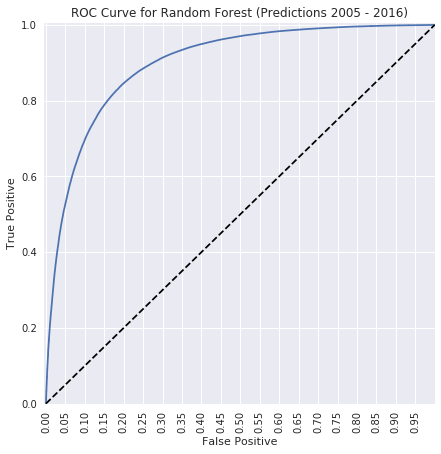

In [23]:
y3_pred_rf2 = rf_classifier2.predict(X3)
y3_pred_probas_rf2 = rf_classifier2.predict_proba(X3)[:, 1]
print('Accuracy on Test: {}'.format(accuracy_score(y3, y3_pred_rf2)))
print()
print(pd.crosstab(y3, y3_pred_rf2))
print()
print(classification_report(y3, y3_pred_rf2))
rf2_X2_auc = plot_AUC(y3, y3_pred_probas_rf2, 'Random Forest (Predictions 2005 - 2016)')

As we can see from the AUC and the ROC curve the 'similarity vectors' created using the link prediction coefficients and w2v similarities performed extremely well with near ~90% AUC on every bit of test data we threw at it, the classification indicating a recall value of between 79-83%. 

While there is still room from improvement this is a very promising score especially with the targeted audience of this project. It's not easy to determine a good subject or idea to research and with so many different fields and subfields it confounds this phenomenon even more, BUT given their domain expertise users of such a solution could indicate their subjects of interest and the algorithm could output highly probable links to explore and the human element can determine the feasibility of the idea given their current available knowledge.

### Feature Importances:

Since random forests models performed best, I decided to visualize the feature importances as a proportion of the total importance of features( % importance ). The 'similarity vectors' we created were a list of measurments determined by proximity in word vector space and connectivity in graph space as such we have an idea of what they represent within the context of the graph but not within the context of the model. Feature importances let's us give a 'weight' to what features influenced the model the most.


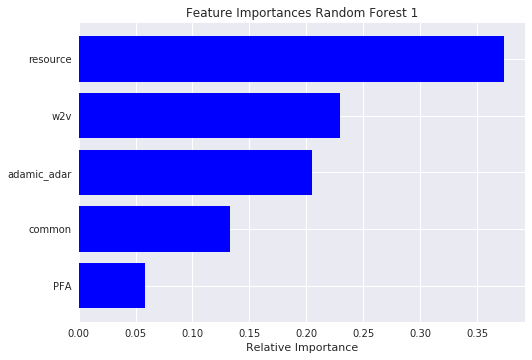

In [24]:
features = X_testG2.columns.values
importances = rf_classifier2.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances Random Forest 1')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

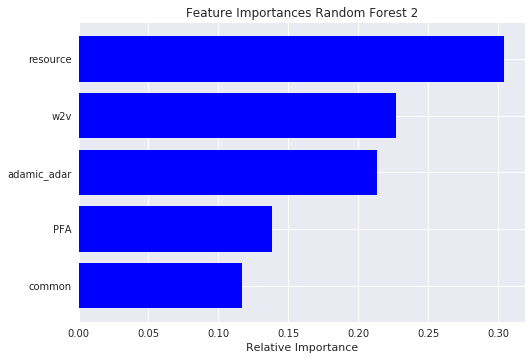

In [25]:
features = X_testG1.columns.values
importances = rf_classifier1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances Random Forest 2')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Resource allocation index seems to be the most important feature in this case, considering that this index scales inversely with the # of common neighbors. Originally going into this I thought those features with positive correlation to the amount of common neighbors would be the ones the ones that wer emore informative, the resutl is the opposite.